# Objective: 

The primary aim of this analysis is to understand the passenger booking behavior and preferences in different facets of their air travel experience. We perform an extensive ETL process to ensure the data is extracted from various sources, transformed into a useful format, and loaded into our SQL database.

Here's an overview of the ETL steps we've performed:

Data Extraction: Our original data, stored in a CSV file, is loaded into a pandas DataFrame for easy manipulation and analysis. This dataset comprises a wealth of information on passenger bookings, including details like the number of passengers, booking origin, flight details, and customer preferences for in-flight meals, extra baggage, and preferred seating.

Data Transformation: We perform several transformations to prepare our data for analysis. These transformations include dropping irrelevant columns, mapping categorical values to numerical equivalents, and truncating string values to avoid any errors when loading data into SQL Server.

Data Loading: We create a new table, 'PassengerBooking', in our SQL Server database. The transformed data is then loaded into this table. Additionally, we divide our dataset into three distinct tables ('Passenger', 'Flight', 'Booking') to improve data organization and enhance the efficiency of our subsequent analyses.

After completing the ETL process, we conduct various analyses to gain insights into:

Booking Completion: Analyze the rate of booking completions to gauge the effectiveness of the booking process.

Booking Origin: Identify the primary geographical regions contributing to the passenger base.

Flight Hour Distribution by Class: Understand the most popular flight hours for each travel class to optimize flight schedules.

In-flight Meals Preference: Analyze the preference for in-flight meals based on the group size, which can assist in planning and resource allocation for in-flight services.

The analysis aims to provide actionable insights that can help improve booking completion rates, enhance customer satisfaction, and optimize operational efficiency.


In [3]:
import pandas as pd
import pyodbc
from sqlalchemy import create_engine

# Database connection parameters
server = 'JOEGAO\\MSSQLSERVER01'
database = 'AirlinePassengerBookingDataBase5'
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes'

# Create a connection
cnxn = pyodbc.connect(connection_string)
cursor = cnxn.cursor()

# Create table query
query = """
CREATE TABLE PassengerBooking (
    num_passengers INT,
    sales_channel VARCHAR(255),
    trip_type VARCHAR(255),
    purchase_lead VARCHAR(255),
    length_of_stay INT,
    flight_hour INT,
    flight_day VARCHAR(255),
    route VARCHAR(255),
    booking_origin VARCHAR(255),
    wants_extra_baggage BIT,
    wants_preferred_seat BIT,
    wants_in_flight_meals BIT,
    flight_duration FLOAT,
    booking_complete BIT,
    Class VARCHAR(255),
    Rating FLOAT,
    Verified BIT
);
"""

# Execute the query
cursor.execute(query)

# Commit the transaction
cnxn.commit()

# Create SQLAlchemy engine
engine = create_engine(f'mssql+pyodbc://{server}/{database}?driver=SQL+Server')

# Load your dataframe from the CSV file
df = pd.read_csv(r'C:\Users\yingf\OneDrive\桌面\CSC423\Project\Passangerbooking.csv', low_memory=False)
# Drop 'Review_title', 'Review_content' columns
df = df.drop(['Review_title', 'Review_content'], axis=1)

# Remove rows where 'Verified' is 'not_verified'
df['Verified'] = df['Verified'].map({'not_verified': 0, 'verified': 1, 'Trip Verified': 1})

# Convert Boolean columns to int
for col, dtype in zip(df.columns, df.dtypes):
    if dtype == bool:
        df[col] = df[col].astype(int)

# Truncate string columns to avoid 'String data, right truncation' error
max_sql_string_size = 510  # Adjust this based on your SQL Server settings
string_cols = df.select_dtypes(include=['object']).columns
df[string_cols] = df[string_cols].apply(lambda series: series.str.slice(0, max_sql_string_size))

# Write DataFrame to SQL
df.to_sql('PassengerBooking', engine, if_exists='append', index=False)


-1

In [16]:
print(df.columns)


Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete', 'Class',
       'Rating', 'Verified'],
      dtype='object')


In [17]:
# Define chunks of dataframe for each table
passenger_df = df[['num_passengers', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']]
flight_df = df[['trip_type', 'flight_hour', 'flight_day', 'route', 'flight_duration', 'Class']]
booking_df = df[['num_passengers','sales_channel', 'booking_origin', 'booking_complete', 'purchase_lead', 'length_of_stay']]

# Now, let's create the tables in the database
passenger_df.to_sql('Passenger', engine, if_exists='append', index=False)
flight_df.to_sql('Flight', engine, if_exists='append', index=False)
booking_df.to_sql('Booking', engine, if_exists='append', index=False)



-1

In [18]:
from sqlalchemy import create_engine

# Create SQLAlchemy engine
engine = create_engine(f'mssql+pyodbc://{server}/{database}?driver=SQL+Server')

# For Passenger table
query = "SELECT * FROM Passenger;"
df_passenger = pd.read_sql_query(query, engine)

df_passenger

,num_passengers,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals
0,1,0,0,0
1,3,0,0,0
2,2,1,1,1
3,1,0,0,0
4,2,1,0,0
...,...,...,...,...
49997,1,0,0,0
49998,4,1,0,0
49999,2,1,0,0
50000,2,1,0,0


In [19]:
# For Flight table
query = "SELECT * FROM Flight;"
df_flight = pd.read_sql_query(query, engine)
print("\nFlight table information:")
df_flight



Flight table information:


,trip_type,flight_hour,flight_day,route,flight_duration,Class
0,RoundTrip,6,Tue,AKLHGH,7.21,Economy Class
1,RoundTrip,7,Sat,AKLDEL,5.52,Business Class
2,RoundTrip,3,Sat,AKLDEL,5.52,Solo Leisure
3,RoundTrip,17,Wed,AKLDEL,5.52,Economy Class
4,RoundTrip,4,Sat,AKLDEL,5.52,Family Leisure
...,...,...,...,...,...,...
49997,RoundTrip,9,Sat,PERPNH,5.62,None
49998,RoundTrip,4,Sun,PERPNH,5.62,None
49999,RoundTrip,22,Sat,PERPNH,5.62,None
50000,RoundTrip,11,Mon,PERPNH,5.62,None


In [20]:
# For Booking table
query = "SELECT * FROM Booking;"
df_Booking = pd.read_sql_query(query, engine)
print("\nBooking table information:")
df_Booking



Booking table information:


,num_passengers,sales_channel,booking_origin,booking_complete,purchase_lead,length_of_stay
0,1,Internet,Australia,1,21,12
1,2,Internet,New Zealand,0,262,19
2,1,Internet,New Zealand,0,112,20
3,2,Internet,India,0,243,22
4,1,Internet,New Zealand,0,96,31
...,...,...,...,...,...,...
49997,2,Internet,Australia,0,27,6
49998,1,Internet,Australia,0,111,6
49999,1,Internet,Australia,0,24,6
50000,1,Internet,Australia,0,15,6


In [21]:
table_list = ['Passenger', 'Flight', 'Booking']

for table in table_list:
    # Query to get the column information
    column_info_query = f"SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = N'{table}';"
    
    # Execute the query
    cursor.execute(column_info_query)

    # Fetch column information
    column_info = cursor.fetchall()
    
    print(f"Table: {table}")
    for column in column_info:
        print(column[0])  # Print the column name

    # Now get the first 3 rows of the table
    rows_query = f"SELECT TOP 3 * FROM {table};"  # TOP keyword is used to limit the number of rows returned
    cursor.execute(rows_query)
    rows = cursor.fetchall()

    print("\nFirst 3 rows:")
    for row in rows:
        print(row)

    print("\n---\n")




Table: Passenger
num_passengers
wants_extra_baggage
wants_preferred_seat
wants_in_flight_meals

First 3 rows:
(1, 0, 0, 0)
(3, 0, 0, 0)
(2, 1, 1, 1)

---

Table: Flight
trip_type
flight_hour
flight_day
route
flight_duration
Class

First 3 rows:
('RoundTrip', 6, 'Tue', 'AKLHGH', 7.21, 'Economy Class')
('RoundTrip', 7, 'Sat', 'AKLDEL', 5.52, 'Business Class')
('RoundTrip', 3, 'Sat', 'AKLDEL', 5.52, 'Solo Leisure')

---

Table: Booking
num_passengers
sales_channel
booking_origin
booking_complete
purchase_lead
length_of_stay

First 3 rows:
(1, 'Internet', 'Australia', 1, 21, 12)
(2, 'Internet', 'New Zealand', 0, 262, 19)
(1, 'Internet', 'New Zealand', 0, 112, 20)

---



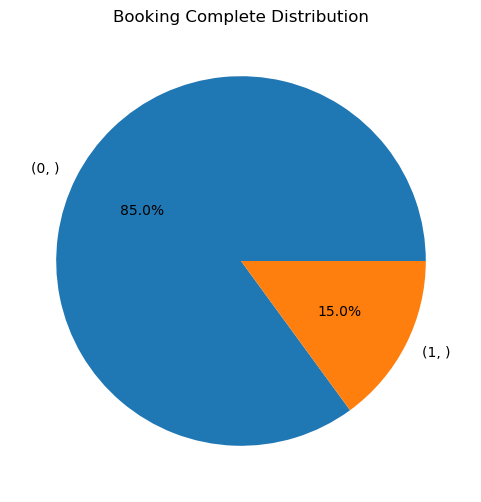

In [22]:
#Booking Complete
import matplotlib.pyplot as plt

# Query to get 'booking_complete' column
booking_query = "SELECT booking_complete FROM Booking;"

# Execute the query
cursor.execute(booking_query)

# Fetch all rows
booking_data = cursor.fetchall()

# Convert the booking_data into a pandas DataFrame
booking_df = pd.DataFrame(booking_data, columns=['booking_complete'])

# Count the occurrence of each value
value_counts = booking_df['booking_complete'].value_counts()

# Create pie chart
plt.figure(figsize=(6,6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Booking Complete Distribution')
plt.show() 

# Analysis of Booking Completion Rates

In our dataset, the booking completion rate stands at approximately 15%. This represents a conversion challenge but also an opportunity for strategic improvements to increase bookings and revenue.

Several factors can impact booking completion rates, including the complexity of the booking process, pricing, personalization, website performance, and customer support.

Optimizing the Booking Process: Simplifying the booking process can reduce abandonment.

Price Optimization: Regularly adjusting pricing strategies can improve completion rates.

Personalization: A tailored user experience can guide customers through the booking process.

Website Performance: Faster website load times can reduce abandonment rates.

Customer Support: Real-time support during booking can address immediate customer concerns.

While a 15% completion rate might seem low, continuous strategic improvements can significantly enhance this metric, thereby improving overall business performance. Constant monitoring of this rate and investigating any changes is vital for maintaining customer satisfaction and conversion.

C:\Users\yingf\AppData\Local\Temp\ipykernel_41648\1232240886.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  booking_data = pd.read_sql(sql_query, conn)


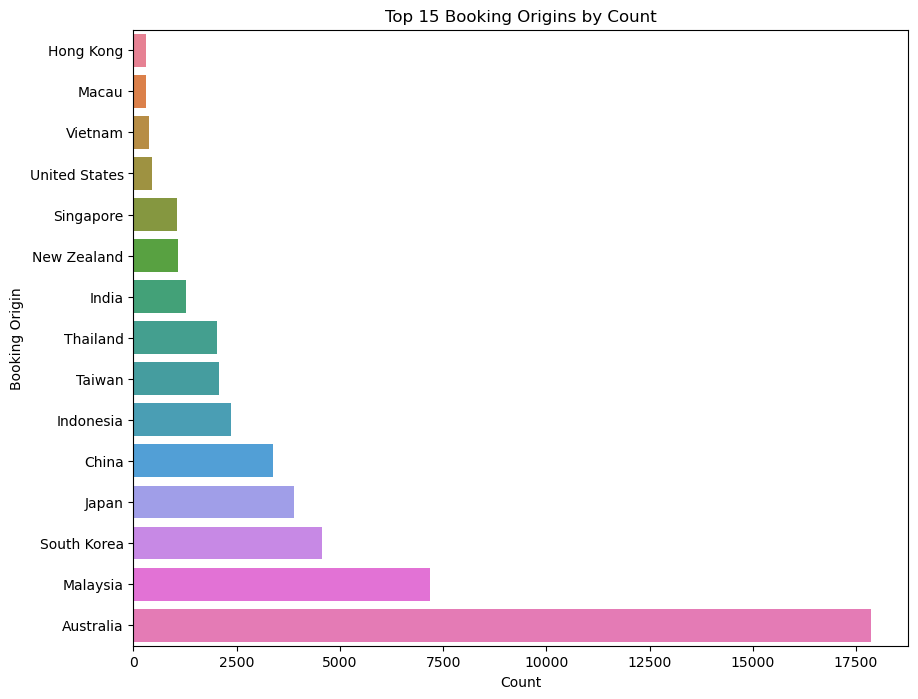

In [11]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection parameters
server = 'JOEGAO\\MSSQLSERVER01'
database = 'AirlinePassengerBookingDataBase3'
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes'

# Connect to the database
with pyodbc.connect(connection_string) as conn:
    # Create a cursor from the connection
    with conn.cursor() as cursor:
        # Write the SQL query
        sql_query = """SELECT TOP 15 booking_origin, COUNT(*) as count 
                       FROM Booking 
                       GROUP BY booking_origin 
                       ORDER BY COUNT(*) DESC;"""

        # Execute the SQL query
        booking_data = pd.read_sql(sql_query, conn)

# Sort data by count
booking_data.sort_values('count', inplace=True)

# Create a color palette
palette = sns.color_palette("husl", 15)

# Plotting
plt.figure(figsize=(10,8))
sns.barplot(x='count', y='booking_origin', data=booking_data, palette=palette)
plt.xlabel('Count')
plt.ylabel('Booking Origin')
plt.title('Top 15 Booking Origins by Count')
plt.show()


# Booking Origin Analysis

The booking origin data provides valuable insights into our customer demographics and helps us understand where most of our customers are located.

Australia: With over 17,500 bookings, Australia stands as the country with the highest number of bookings. This shows a strong customer base in Australia, which could be the result of effective marketing strategies, competitive pricing, or a high demand for our flights in the region.

Malaysia: Following Australia, Malaysia is the second-highest contributor with 7,500 bookings. The high number of bookings could be due to strong business ties or tourism demand.

South Korea: Ranking third with 4,500 bookings, South Korea is another significant market for us. Factors such as travel frequency, flight connectivity, or service satisfaction might be playing a role here.

Japan: Japan comes fourth with 4,000 bookings. The high demand might be due to cultural, business, or tourism-related travel.

China: With 3,500 bookings, China is the fifth top booking origin. The large population and increasing global mobility of Chinese citizens might contribute to this high count.

In summary, these five countries represent the majority of our bookings. Understanding why these specific countries are the highest contributors can help us tailor our marketing strategies and further strengthen our presence in these markets. It's also important to identify growth potential in other regions to diversify our customer base.

C:\Users\yingf\AppData\Local\Temp\ipykernel_41648\3726568963.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  flight_df = pd.read_sql_query(query, conn)


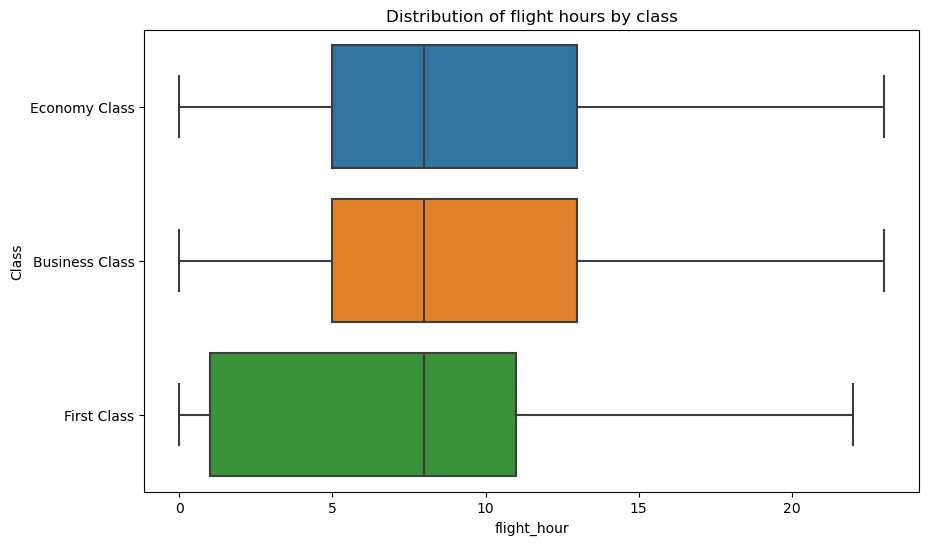

In [12]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Database connection parameters
server = 'JOEGAO\\MSSQLSERVER01'
database = 'AirlinePassengerBookingDataBase3'
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes'

# Connect to the SQL Server database
conn = pyodbc.connect(connection_string)

# Query to get 'flight_hour' and 'Class' columns from 'Flight' table
query = "SELECT flight_hour, Class FROM Flight;"

# Execute the query and convert the result into a pandas DataFrame
flight_df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Filter the dataframe to contain only the 'Economy', 'Business' and 'First' classes
filtered_flight_df = flight_df[flight_df['Class'].isin(['Economy Class', 'Business Class', 'First Class'])]

# Horizontal Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='flight_hour', y='Class', data=filtered_flight_df)
plt.title('Distribution of flight hours by class')
plt.show()



In [13]:
print(filtered_flight_df.groupby('Class')['flight_hour'].describe())
#Business Class: The median flight hour is 8 hours, 
#with 50% of the flights having a flight duration between 5 and 13 hours.
# Economy Class: The median flight hour is also 8 hours, and again, 
# 50% of the flights have a duration between 5 and 13 hours.
# First Class: The median flight hour is 8 hours as well, 
# with the interquartile range between 1 and 11 hours.


                count      mean       std  min  25%  50%   75%   max
Class                                                               
Business Class  183.0  9.076503  5.763150  0.0  5.0  8.0  13.0  23.0
Economy Class   676.0  9.134615  5.677082  0.0  5.0  8.0  13.0  23.0
First Class      11.0  7.636364  6.975281  0.0  1.0  8.0  11.0  22.0


# Distribution of Flight Hours by Class Analysis

An understanding of the relationship between flight duration and the class chosen by passengers can help us optimize our service offerings.

First Class: The data suggests that First Class is predominantly chosen for flights of less than 12 hours. This could be indicative of passengers opting for First Class due to the premium services and comfort it offers on direct, non-stop flights. Longer flight durations could mean layovers, and passengers might not see the value in paying a premium if they'll be off the plane for a significant portion of the journey.

Economy and Business Class: Both these classes are typically chosen for flights lasting between 5 to 15 hours. This could be because these options provide a balance between comfort and cost-effectiveness, which appeals to passengers on medium to long-haul flights. Moreover, these flights could include a mix of non-stop and one-stop flights, where passengers might be willing to compromise on comfort due to the layover.

Understanding these trends can help us in various ways. For instance, we could consider offering more amenities in Economy and Business Class on longer flights to encourage upgrades. Similarly, promoting the benefits of First Class on shorter, direct flights might attract more passengers to choose this option. This analysis could also aid in strategic decisions such as flight scheduling, fleet utilization, and service optimization to enhance passenger experience and increase revenue.

C:\Users\yingf\AppData\Local\Temp\ipykernel_41648\3673596808.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(sql_query, conn)


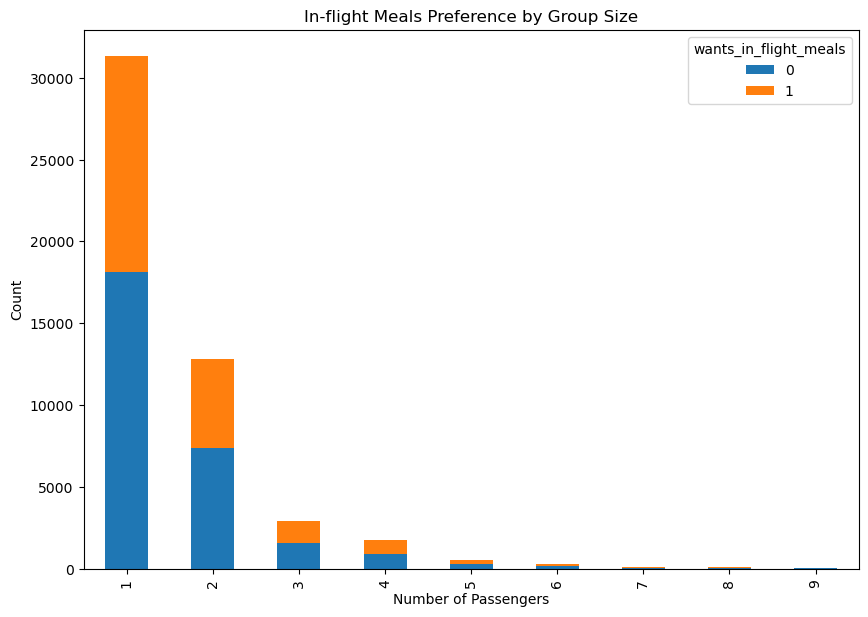

In [14]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

# Database connection parameters
server = 'JOEGAO\\MSSQLSERVER01'
database = 'AirlinePassengerBookingDataBase3'
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes'

# Connect to the database
with pyodbc.connect(connection_string) as conn:
    # Create a cursor from the connection
    with conn.cursor() as cursor:
        # Write the SQL query
        sql_query = """SELECT num_passengers, wants_in_flight_meals, COUNT(*) as count 
                       FROM Passenger 
                       GROUP BY num_passengers, wants_in_flight_meals"""

        # Execute the SQL query
        data = pd.read_sql(sql_query, conn)

# Pivot data for plotting
pivot_data = data.pivot(index='num_passengers', columns='wants_in_flight_meals', values='count').fillna(0)

# Plotting
pivot_data.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Number of Passengers')
plt.ylabel('Count')
plt.title('In-flight Meals Preference by Group Size')
plt.show()


# In-flight Meals Preference Analysis

Understanding passenger preferences for in-flight meals can play a crucial role in enhancing customer satisfaction and optimizing meal planning and catering costs.

The analysis reveals a notable difference in meal preferences based on the group size:

Group Sizes 1 & 2: Single passengers and groups of two seem to lean towards not having in-flight meals. This could be due to a number of factors, such as dietary restrictions, personal preferences, or cost considerations. For these smaller groups or individuals, meal selection might not be a significant part of their flight experience.

Group Sizes 3, 4, & 5: Conversely, larger groups, including groups of 3, 4, or 5 passengers, show a higher interest in in-flight meals. It is plausible that these groups consist of families traveling together. Sharing meals can be an integral part of the family travel experience. Moreover, the convenience of pre-arranged meals may be more appealing for larger groups or families with children.

Understanding these preferences can help our airline effectively cater to passenger needs. For example, we can provide more food options or meal customization for larger groups. Conversely, we can explore alternatives to traditional meals, like snack boxes or light fare, for single passengers or smaller groups. This information can also be useful in forecasting demand for in-flight meals and reducing food waste.

# Conclusion

Our comprehensive analysis has provided several interesting insights that could assist us in delivering a superior customer experience, optimizing operations, and implementing effective strategies.

Booking Completion: Our data reveals a surprisingly low booking completion rate at just 15%. This necessitates immediate investigation to identify and address barriers in the booking process that could be discouraging customers from finalizing their reservations.

Top Booking Origins: We've identified the top 15 booking origins, with Australia leading the pack by a considerable margin. Understanding the characteristics of these markets can enable us to tailor our services and marketing strategies to meet the needs of these customers more effectively.

Flight Hour by Class: Our findings also show a clear correlation between flight duration and class selection. Passengers tend to prefer First Class for shorter, non-stop flights, while Business and Economy classes are chosen for moderately long flights. This information can assist in planning flight schedules and optimizing cabin configurations.

In-flight Meals Preference: We discovered that meal preferences vary significantly based on group size, with larger groups more likely to opt for in-flight meals. This is a valuable insight for our in-flight services planning, helping us tailor our meal offerings to match customer preferences.

Through the application of these insights, we can improve customer satisfaction, increase booking completion rates, and enhance overall operational efficiency. However, continuous analysis and adaptation are crucial to ensure that we keep up with the dynamic nature of consumer behavior in the aviation industry.


Reference:
https://www.transportation.gov/
https://hevodata.com/learn/python-sql-server-integration/
https://www.sqlalchemy.org/
https://matplotlib.org/
https://www.w3schools.com/python/pandas/default.asp
